In [ ]:
import numpy as np
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Loading the Dataset

In [ ]:
# Function to read a file and extract information
def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        documents = {}
        current_doc = None
        for line in lines:
            if line.startswith('Document'):
                if current_doc is not None:
                    documents.append(current_doc)
                else:
                    doc_id = int(line.split()[1])
                    current_doc = {'doc_id': doc_id, 'content': ''}
            elif line.startswith('*********'):
                if current_doc is not None:
                    documents[current_doc['doc_id']] = current_doc['content']
                    current_doc = None
            elif current_doc:
                current_doc['content'] += line.strip() + ' '

        if current_doc is not None:
            documents.append(current_doc)

        return documents

In [ ]:
# Directory where the files are located
directory = '/docs'

# List to store the document information
documents = {}

# Read each file in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    doc_info = read_file(file_path)
    documents.update(doc_info)

In [ ]:
queries = {}
with open('/LISA.QUE', 'r') as file:
    lines = file.readlines()
    q = None
    i = 0
    for line in lines:
        if q is None:
            q = ''
            i = int(line.strip())
        elif line.strip().endswith('#'):
            queries[i] = q
            q = None
        else:
            q += line.strip() + ' '

In [ ]:
results = {}
with open('/LISA.REL', 'r') as file:
    lines = file.readlines()
    i = 0
    answers = False
    for line in lines:
        if line.startswith('Query'):
            i = int(line.split()[1])
            results[i] = []
        elif line.strip().endswith('Relevant Refs:'):
            answers = True
        elif answers:
            l = list(map(int, line.strip().split()))
            if l[-1] == -1:
                answers = False
                results[i].extend(l[:-1])
            else:
                results[i].extend(l)

# Preprocessing

In [ ]:
for i in queries.keys() - results.keys():
    queries.pop(i)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

In [ ]:
documents = {key: process(value) for key, value in documents.items()}
queries = {key: process(value) for key, value in queries.items()}

**Tokenizing, stemming and removing stopwords**

In [ ]:
sw_set = set(nltk.corpus.stopwords.words('english'))
# Create a stemmer object
stemmer = PorterStemmer()

def token_stemm_sw(x):
    words = word_tokenize(x)
    filtered_list = [stemmer.stem(word) for word in words if word not in sw_set]
    return filtered_list

In [ ]:
documents = {key: token_stemm_sw(value) for key, value in documents.items()}
queries = {key: token_stemm_sw(value) for key, value in queries.items()}

**Saving two samples from the result of preprocessing**

In [ ]:
path = '/1.txt'
with open(path, 'w') as file:
    file.write('1:\n')
    for item in documents[1]:
        file.write(str(item) + ' ')
    file.write('\n2:\n')
    for item in documents[2]:
        file.write(str(item) + ' ')

**Term count**

In [ ]:
terms = set(chain(*documents.values()))

In [ ]:
print('Number of uniqe terms in the documents: ', len(terms))

Number of uniqe terms in the documents:  11928


In [ ]:
q_terms = set(chain(*queries.values()))
print('Number of uniqe terms in the queries: ', len(q_terms))

Number of uniqe terms in the queries:  416


In [ ]:
print('Total number of uniqe terms in the queries: ', len(terms.union(q_terms)))

Total number of uniqe terms in the queries:  11944


In [ ]:
# Extract document texts and IDs
document_texts = list(documents.values())
document_ids = list(documents.keys())

# Extract query texts from the dictionary
query_texts = list(queries.values())

# TF-IDF

In [ ]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Compute TF-IDF scores for documents
tfidf_matrix_documents = vectorizer.fit_transform([' '.join(text) for text in document_texts])

# Compute TF-IDF scores for queries
tfidf_matrix_queries = vectorizer.transform([' '.join(text) for text in query_texts])

# Compute cosine similarity between queries and documents
cosine_similarities = cosine_similarity(tfidf_matrix_queries, tfidf_matrix_documents)

In [ ]:
related5 ={}
related10 ={}
related20 ={}
related40 ={}

for query_id, _ in queries.items():
    query_index = list(queries.keys()).index(query_id)
    similarity_scores = cosine_similarities[query_index]
    sorted_indices = similarity_scores.argsort()[::-1]

    related5[query_id] = [document_ids[i] for i in sorted_indices[:5]]
    related10[query_id] = [document_ids[i] for i in sorted_indices[:10]]
    related20[query_id] = [document_ids[i] for i in sorted_indices[:20]]
    related40[query_id] = [document_ids[i] for i in sorted_indices[:40]]

**Evaluation**

In [ ]:
def evaluate(query_results, ground_truth):
    tp = 0
    fp = 0
    fn = 0

    for query_id, retrieved_documents in query_results.items():
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        ground_truth_documents = ground_truth[query_id]

        # Count true positives
        for doc_id in retrieved_documents:
            if doc_id in ground_truth_documents:
                true_positives += 1

        # Count false positives
        false_positives += len(retrieved_documents) - true_positives

        # Count false negatives
        false_negatives += len(ground_truth_documents) - true_positives


        tp += true_positives
        fp += false_positives
        fn += false_negatives

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score


In [ ]:
# Call the evaluate_ir function for four scenarios
precision_1, recall_1, f1_score_1 = evaluate(related5, results)
precision_2, recall_2, f1_score_2 = evaluate(related10, results)
precision_3, recall_3, f1_score_3 = evaluate(related20, results)
precision_4, recall_4, f1_score_4 = evaluate(related40, results)

# Create a table
table = [
    ["number of related documents extracted", "Precision", "Recall", "F1-Score"],
    ["5", precision_1, recall_1, f1_score_1],
    ["10", precision_2, recall_2, f1_score_2],
    ["20", precision_3, recall_3, f1_score_3],
    ["40", precision_4, recall_4, f1_score_4]
]

# Print the table
print(tabulate(table, headers="firstrow"))


  number of related documents extracted    Precision    Recall    F1-Score
---------------------------------------  -----------  --------  ----------
                                      5     0.278788  0.129577    0.176923
                                     10     0.230303  0.214085    0.221898
                                     20     0.166667  0.309859    0.216749
                                     40     0.111364  0.414085    0.175522


# LSI

In [ ]:
# Perform LSI on the TF-IDF matrix
lsi = TruncatedSVD(n_components=2)
lsi_matrix_documents = lsi.fit_transform(tfidf_matrix_documents)
lsi_matrix_queries = lsi.transform(tfidf_matrix_queries)

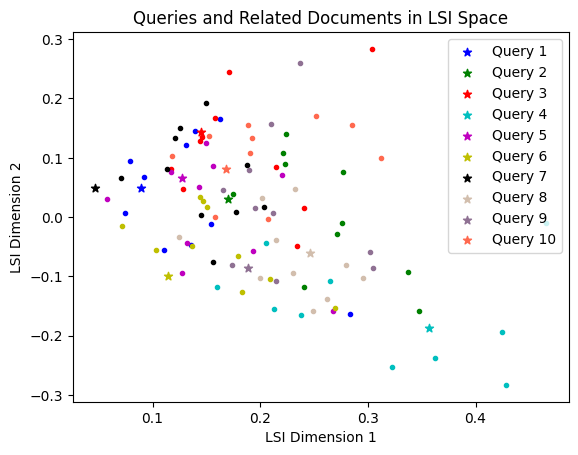

In [ ]:
# Plot the queries and their related documents

colors= ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#d2bead', '#8f7193', '#ff694f']

fig, ax = plt.subplots()
for query_id in range(1, 11):
    query_index = list(queries.keys()).index(query_id)
    query_vector = lsi_matrix_queries[query_index]

    ax.scatter(query_vector[0], query_vector[1], marker='*', color=colors[query_id-1], label=f"Query {query_id}")
    for doc_id in related10[query_id]:
        doc_index = document_ids.index(doc_id)
        doc_vector = lsi_matrix_documents[doc_index]
        ax.scatter(doc_vector[0], doc_vector[1], marker='.', color=colors[query_id-1])
        # ax.annotate(str(doc_id), (doc_vector[0], doc_vector[1]))

# Set labels and title
ax.set_xlabel("LSI Dimension 1")
ax.set_ylabel("LSI Dimension 2")
ax.set_title("Queries and Related Documents in LSI Space")

# Show legend
ax.legend()

# Show the plot
plt.show()
